2023-04-03 09:59:53.166485: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 09:59:53.169129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 09:59:53.224956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 09:59:53.226083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 09:59:54.140154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

dict_keys(['ADT_loc', 'ADTnoseason_loc', 'LAT', 'LON', 'PRES', 'RHO', 'SAL', 'SH1950', 'SIG', 'SPICE', 'TEMP', 'TIME'])


2023-04-03 10:00:10.040545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
50/50 - 3s - loss: 256.8415 - val_loss: 44.5309 - 3s/epoch - 63ms/step
Epoch 2/50
50/50 - 2s - loss: 27.5631 - val_loss: 9.0386 - 2s/epoch - 44ms/step
Epoch 3/50
50/50 - 2s - loss: 4.4039 - val_loss: 1.2663 - 2s/epoch - 36ms/step
Epoch 4/50
50/50 - 2s - loss: 1.0362 - val_loss: 0.8374 - 2s/epoch - 37ms/step
Epoch 5/50
50/50 - 2s - loss: 0.7129 - val_loss: 0.5134 - 2s/epoch - 39ms/step
Epoch 6/50
50/50 - 2s - loss: 0.4179 - val_loss: 0.3050 - 2s/epoch - 36ms/step
Epoch 7/50
50/50 - 2s - loss: 0.2554 - val_loss: 0.2103 - 2s/epoch - 37ms/step
Epoch 8/50
50/50 - 2s - loss: 0.1981 - val_loss: 0.1757 - 2s/epoch - 36ms/step
Epoch 9/50
50/50 - 2s - loss: 0.1717 - val_loss: 0.1594 - 2s/epoch - 36ms/step
Epoch 10/50
50/50 - 2s - loss: 0.1577 - val_loss: 0.1493 - 2s/epoch - 35ms/step
Epoch 11/50
50/50 - 2s - loss: 0.1453 - val_loss: 0.1327 - 2s/epoch - 36ms/step
Epoch 12/50
50/50 - 2s - loss: 0.1300 - val_loss: 0.1202 - 2s/epoch - 38ms/step
Epoch 13/50
50/50 - 2s - loss: 0.1202 - val_l

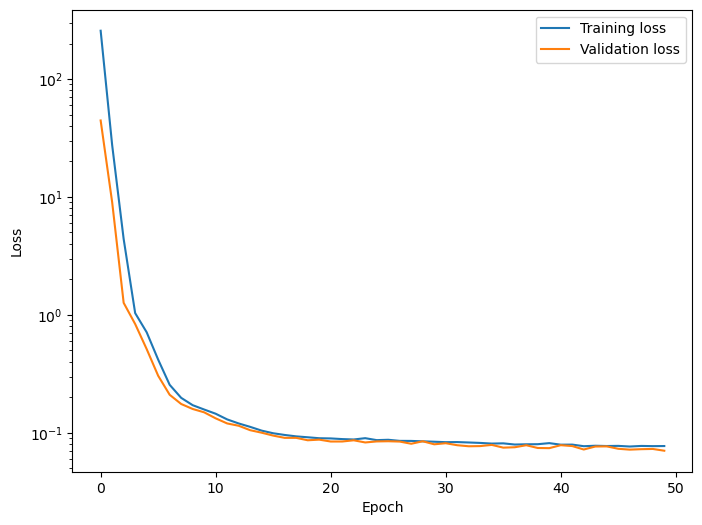

7/7 [==============================] - 0s 5ms/step


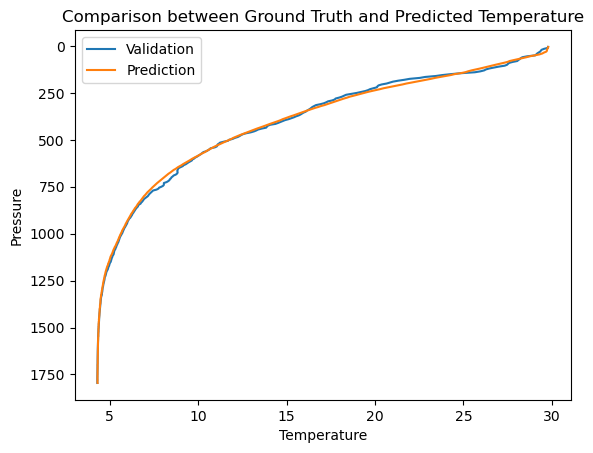

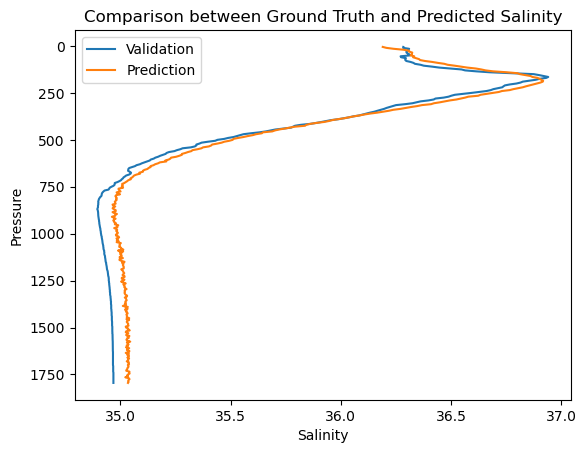

7/7 [==============================] - 0s 5ms/step - loss: 0.0706
MSE on validation set: 0.07056090235710144


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load data from MATLAB files using mat73 library
ARGO = mat73.loadmat('ARGO_GoM_20220920.mat', use_attrdict=True)

# Display keys in the loaded ARGO data
print(ARGO.keys())

# Extract and display the relevant arrays from the ARGO variable
pres = np.arange(5, 1800, 5, dtype=int)  # index
sal = ARGO.SAL[pres, :]
temp = ARGO.TEMP[pres, :]
lat = ARGO.LAT
lon = ARGO.LON
ssh = ARGO.SH1950

# Data cleaning: remove profiles with NaNs
nan_index = np.logical_or(np.isnan(sal).any(axis=0), np.isnan(temp).any(axis=0))
sal = sal[:, ~nan_index]
temp = temp[:, ~nan_index]
lat = lat[~nan_index]
lon = lon[~nan_index]
ssh = ssh[~nan_index]

# Concatenate the input arrays into a single 2D array
X = np.column_stack((ssh, np.mean(temp[:1, :], axis=0)))

# Reshape the output arrays into a 2D array
y = np.column_stack((temp.T, sal.T))

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Find the indices of rows without NaN values
valid_idx = np.where(~np.isnan(X).any(axis=1))[0]

# Select a random subset of the valid rows
np.random.seed(42)
subset_idx = np.random.choice(valid_idx, size=2000, replace=False)

# Split the selected subset into training, validation, and testing sets
X_subset = X[subset_idx]
y_subset = y[subset_idx]
X_train, X_val_test, y_train, y_val_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Normalize the input data using z-score normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2001 * 2, activation=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(718, activation=None)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with progress indicator
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[tensorboard_callback], verbose=2)

# Evaluate the model on test set
mse_test = model.evaluate(X_test, y_test)

# Use the model for predictions
X_new = np.array([[2.5, 20.0]]) # example input
X_new = scaler.transform(X_new)
y_pred = model.predict(X_new)

# Save the model
model.save('model.h5')

# Plot the loss history during training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate predictions on validation set
y_pred = model.predict(X_val)

# Plot comparison between predictions and ground truth for temperature
value = 0 # index of the selected profile
plt.plot(y_val[value, :359], pres, label='Validation')
plt.plot(y_pred[value, :359], pres, label='Prediction')
plt.title('Comparison between Ground Truth and Predicted Temperature')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Temperature')
plt.legend()
plt.show()

# Plot comparison between predictions and ground truth for salinity
plt.plot(y_val[value, 359:], pres, label='Validation')
plt.plot(y_pred[value, 359:], pres, label='Prediction')
plt.title('Comparison between Ground Truth and Predicted Salinity')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Salinity')
plt.legend()
plt.show()

# Calculate and print mean squared error on validation set
mse_val = model.evaluate(X_val, y_val)
print('MSE on validation set:', mse_val)

In [8]:
import os

# Create a folder for saving figures, if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# Define a function to plot the selected profile
def plot_profile(profile_idx):
    plt.clf()
    # Get the input values used for the prediction
    ssh = scaler.inverse_transform(X_val[profile_idx:profile_idx+1, :2])[0, 0]
    sst = scaler.inverse_transform(X_val[profile_idx:profile_idx+1, :2])[0, 1]
    
    # Mean squared error
    mse_t = np.mean((y_pred[i, :359] - y_val[i, :359])**2)
    mse_s = np.mean((y_pred[i, 359:] - y_val[i, 359:])**2)
    
    # Create the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    # Plot the temperature
    axs[0].plot(y_val[profile_idx, :359], pres, label='Validation')
    axs[0].plot(y_pred[profile_idx, :359], pres, label='Prediction')
    axs[0].set_title(f'Temperature \nMSE={mse_t:.4f}')
    axs[0].set_xlabel('Temperature (°C)')
    axs[0].set_ylabel('Pressure (dbar)')
    axs[0].legend()
    # Plot the salinity
    axs[1].plot(y_val[profile_idx, 359:], pres, label='Validation')
    axs[1].plot(y_pred[profile_idx, 359:], pres, label='Prediction')
    axs[1].set_title(f'Salinity \nMSE={mse_s:.4f}')
    axs[1].set_xlabel('Salinity (PSU)')
    axs[1].legend()
    axs[0].invert_yaxis()
    
    fig.suptitle(f'Profile {profile_idx+1}, SST={sst:.1f}, SSH={ssh:.1f}')
    
    # Save the figure
    iter_num = profile_idx + 1
    filename = f"figures/NN_GEM_{iter_num:03d}.jpg"
    plt.savefig(filename)
    # # Show the figure
    # plt.show()
    plt.clf()

# Loop over the 200 cases and create the plots
for i in range(200):
    # Create and save the plot for the current profile
    plot_profile(i)
    plt.clf()

/tmp/ipykernel_24559/3705043294.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>